# Encoder-Decoder - 3000 samples - softmax 

## Run Settings 

In [75]:
%run run_model.py

## Settings 

In [76]:
batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 3000  # Number of samples to train on.
# Path to the data txt file on disk.
test_size = 100
complete_corpus_path = 'Corpus/corpus4938.csv'

train_file, test_file = load_train_test(corpus = complete_corpus_path, num_samples=num_samples, test_size=test_size)

## Vectorize Data

In [41]:
# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(train_file, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text = line.split(';')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

# Dictionary of tokens
input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

Number of samples: 3000
Number of unique input tokens: 26
Number of unique output tokens: 32
Max sequence length for inputs: 15
Max sequence length for outputs: 16


## Model

In [266]:
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [267]:
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
filename = 'Models/model5.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

## Run Training 

In [37]:
%%time
# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit([encoder_input_data, decoder_input_data],
                    decoder_target_data,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.2,verbose=2, callbacks=[checkpoint])

Train on 2400 samples, validate on 600 samples
Epoch 1/100
Epoch 00001: val_loss improved from 1.31209 to 1.12663, saving model to Models/model5.h5


/Users/Beatriz/Dropbox/Linguística/algoritmos/principal/WickelfeaturesProject/mestrado/lib/python3.6/site-packages/keras/engine/topology.py:2344: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_1/while/Exit_2:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'lstm_1/while/Exit_3:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  str(node.arguments) + '. They will not be included '


 - 11s - loss: 1.1187 - acc: 0.1757 - val_loss: 1.1266 - val_acc: 0.2010
Epoch 2/100
Epoch 00002: val_loss improved from 1.12663 to 1.04979, saving model to Models/model5.h5
 - 10s - loss: 0.9993 - acc: 0.2036 - val_loss: 1.0498 - val_acc: 0.2106
Epoch 3/100
Epoch 00003: val_loss improved from 1.04979 to 0.94620, saving model to Models/model5.h5
 - 11s - loss: 0.9057 - acc: 0.2251 - val_loss: 0.9462 - val_acc: 0.2351
Epoch 4/100
Epoch 00004: val_loss did not improve
 - 10s - loss: 0.8421 - acc: 0.2402 - val_loss: 0.9709 - val_acc: 0.2196
Epoch 5/100
Epoch 00005: val_loss improved from 0.94620 to 0.88096, saving model to Models/model5.h5
 - 10s - loss: 0.7868 - acc: 0.2532 - val_loss: 0.8810 - val_acc: 0.2502
Epoch 6/100
Epoch 00006: val_loss improved from 0.88096 to 0.80939, saving model to Models/model5.h5
 - 10s - loss: 0.7444 - acc: 0.2634 - val_loss: 0.8094 - val_acc: 0.2680
Epoch 7/100
Epoch 00007: val_loss did not improve
 - 10s - loss: 0.6980 - acc: 0.2766 - val_loss: 0.8323 - v

## Save Results 

In [50]:
with open('Files/train_history_model5', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [38]:
# Save Weights
save_path = '3000-softmax-no-dropout.h5'
model.save_weights('Models/' + save_path)

In [39]:
%matplotlib inline
# list all data in history
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


## Summary and Plots 

|     Model Name     | Test File     | Best Epoch Score | val_acc | val_loss | loss | acc    | Time|
|:------------------:|---------------|-----------------:|---------|----------|------|--------|-----|
| Model5.h5    | Corpus/test100verbs.csv      |   54    |  0.423  |  0.340   | 0.030|0.4789  |15 min|

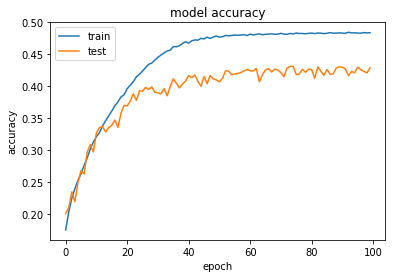

In [51]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

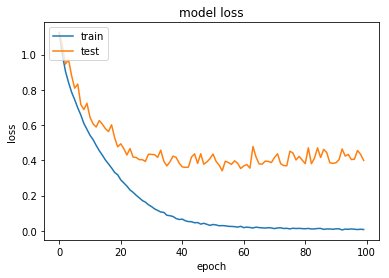

In [53]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

## Inference Mode 

In [47]:
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.load_weights('Models/3000-softmax-no-dropout.h5')

# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())

## Test it on training set 

In [45]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [62]:
def encode_sequence(sentence, encoding_dict = input_token_index):
    encoder_input_data = np.zeros((1,max_encoder_seq_length,len(encoding_dict)))
    for t, char in enumerate(sentence):
        encoder_input_data[0,t, encoding_dict[char]] = 1.
    return encoder_input_data 

In [63]:
def predictions(df_test):
    
    df_test['enconding'] = df_test.infinitivo.apply(encode_sequence).apply(decode_sequence)
    return test

In [66]:
def predictions(df_test):
    
    df_test['enconding'] = df_test.infinitivo.apply(encode_sequence).apply(decode_sequence)
    return df_test

In [48]:
for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

-
Input sentence: ir
Decoded sentence: vou

-
Input sentence: ser
Decoded sentence: sou

-
Input sentence: fazer
Decoded sentence: faço

-
Input sentence: amar
Decoded sentence: amo

-
Input sentence: estar
Decoded sentence: estou

-
Input sentence: ver
Decoded sentence: vejo

-
Input sentence: vir
Decoded sentence: venho

-
Input sentence: ter
Decoded sentence: tenho

-
Input sentence: poder
Decoded sentence: posso

-
Input sentence: dar
Decoded sentence: dou

-
Input sentence: haver
Decoded sentence: hei

-
Input sentence: partir
Decoded sentence: parto

-
Input sentence: comer
Decoded sentence: como

-
Input sentence: pôr
Decoded sentence: ponho

-
Input sentence: dizer
Decoded sentence: digo

-
Input sentence: estudar
Decoded sentence: estudo

-
Input sentence: falar
Decoded sentence: falo

-
Input sentence: cantar
Decoded sentence: canto

-
Input sentence: rir
Decoded sentence: rio

-
Input sentence: sair
Decoded sentence: saio

-
Input sentence: querer
Decoded sentence: quero

-


In [80]:
decode_sequence(encode_sequence("escurecer"))

'escureço\n'

## Test it on the Testing set 

In [256]:
df_Test = load_test(test_file)

In [257]:
df_Test['encoding'] = df_Test.iloc[:60].infinitivo.apply(encode_sequence).apply(decode_sequence)

In [258]:
df_Test.head(60).values

array([['deformar', 'deformo', 'deforrio\n'],
       ['inferiorizar', 'inferiorizo', 'infirro\n'],
       ['ticar', 'tico', 'tico\n'],
       ['traquear', 'traqueio', 'tranjo\n'],
       ['desencantar', 'desencanto', 'desencanto\n'],
       ['excetuar', 'excetuo', 'executo\n'],
       ['acarear', 'acareio', 'acarelo\n'],
       ['chispar', 'chispo', 'chiso\n'],
       ['drenar', 'dreno', 'redeno\n'],
       ['encarcerar', 'encarcero', 'encarero\n'],
       ['fustigar', 'fustigo', 'fustio\n'],
       ['ilidir', 'ilido', 'ilido\n'],
       ['maximizar', 'maximizo', 'mamigizo\n'],
       ['quantificar', 'quantifico', 'quantifico\n'],
       ['reconquistar', 'reconquisto', 'reconsilio\n'],
       ['talhar', 'talho', 'talho\n'],
       ['tralhar', 'tralho', 'tralho\n'],
       ['verear', 'vereio', 'verezo\n'],
       ['alarmar', 'alarmo', 'alarro\n'],
       ['dissimular', 'dissimulo', 'dissumplido\n'],
       ['ortografar', 'ortografo', 'ootrego\n'],
       ['regatear', 'regateio', 'regato

In [259]:
def test_accuracy(df, len_test):
    df_Test['encoding'] = df_Test['encoding'].apply(lambda x: str(x)[:-1])

    df_Test['conjugado'] = df_Test['conjugado'].apply(lambda x: str(x))

    df = df_Test

    matches = df[df['encoding'] == df['conjugado']]

    return float(len(matches))/len_test 

In [260]:
test_accuracy(df_Test, 60)

0.38333333333333336

---

# Encoder-Decoder - Phonetic Transcription - 325 samples - softmax

## Run Settings 

In [75]:
%run run_model.py

## Settings 

In [261]:
batch_size = 64  # Batch size for training.
epochs = 130  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 325  # Number of samples to train on.
# Path to the data txt file on disk.
test_size = 100
complete_corpus_path = 'Corpus/train_lstm_corpus.csv'

train_file, test_file = load_train_test(corpus = complete_corpus_path, 
                                        num_samples=num_samples, 
                                        test_size=test_size)

## Vectorize Data

In [262]:
# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(train_file, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text = line.split(';')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

# Dictionary of tokens
input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

Number of samples: 325
Number of unique input tokens: 22
Number of unique output tokens: 26
Max sequence length for inputs: 11
Max sequence length for outputs: 13


## Model

In [268]:
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [269]:
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
filename = 'Models/model6.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

## Run Training 

In [270]:
%%time
# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit([encoder_input_data, decoder_input_data],
                    decoder_target_data,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.2,verbose=2, callbacks=[checkpoint])

Train on 260 samples, validate on 65 samples
Epoch 1/130
Epoch 00001: val_loss improved from inf to 1.64417, saving model to Models/model6.h5


/Users/Beatriz/Dropbox/Linguística/algoritmos/principal/WickelfeaturesProject/mestrado/lib/python3.6/site-packages/keras/engine/topology.py:2344: UserWarning: Layer lstm_18 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_17/while/Exit_2:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'lstm_17/while/Exit_3:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  str(node.arguments) + '. They will not be included '


 - 3s - loss: 1.8408 - acc: 0.0879 - val_loss: 1.6442 - val_acc: 0.1053
Epoch 2/130
Epoch 00002: val_loss improved from 1.64417 to 1.53985, saving model to Models/model6.h5
 - 1s - loss: 1.5961 - acc: 0.1154 - val_loss: 1.5398 - val_acc: 0.1385
Epoch 3/130
Epoch 00003: val_loss improved from 1.53985 to 1.52422, saving model to Models/model6.h5
 - 1s - loss: 1.5367 - acc: 0.1402 - val_loss: 1.5242 - val_acc: 0.1420
Epoch 4/130
Epoch 00004: val_loss did not improve
 - 1s - loss: 1.5248 - acc: 0.1464 - val_loss: 1.5534 - val_acc: 0.0805
Epoch 5/130
Epoch 00005: val_loss improved from 1.52422 to 1.47230, saving model to Models/model6.h5
 - 1s - loss: 1.5240 - acc: 0.1308 - val_loss: 1.4723 - val_acc: 0.1680
Epoch 6/130
Epoch 00006: val_loss did not improve
 - 1s - loss: 1.4877 - acc: 0.1464 - val_loss: 1.9398 - val_acc: 0.0497
Epoch 7/130
Epoch 00007: val_loss did not improve
 - 1s - loss: 1.6059 - acc: 0.1388 - val_loss: 1.4766 - val_acc: 0.1763
Epoch 8/130
Epoch 00008: val_loss improved 

## Save Results 

In [271]:
with open('Files/train_history_model6', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [272]:
# Save Weights
save_path = '325phonetic-transcription-softmax-no-dropout.h5'
model.save_weights('Models/' + save_path)

In [273]:
%matplotlib inline
# list all data in history
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


In [277]:
print(history.history['val_acc'][96],
history.history['val_loss'][96],
history.history['loss'][96],
history.history['acc'][96])

0.34319526644853443 0.8674051908346323 0.2903436940449935 0.508579890544598


## Summary and Plots 

|     Model Name     | Test File     | Best Epoch Score | val_acc | val_loss | loss | acc    | Time|
|:------------------:|---------------|-----------------:|---------|----------|------|--------|-----|
| Model6.h5    | Corpus/test1001534626149verbs.csv      |   97    |  0.342  |  0.867   | 0.290|0.5085  |2 min|

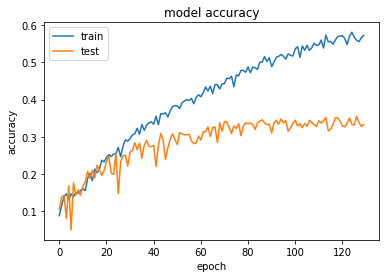

In [278]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

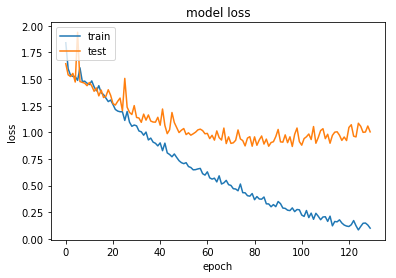

In [279]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

## Inference Mode 

In [281]:
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.load_weights('Models/325phonetic-transcription-softmax-no-dropout.h5')

# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())

## Test it on training set 

In [282]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [283]:
def encode_sequence(sentence, encoding_dict = input_token_index):
    encoder_input_data = np.zeros((1,max_encoder_seq_length,len(encoding_dict)))
    for t, char in enumerate(sentence):
        encoder_input_data[0,t, encoding_dict[char]] = 1.
    return encoder_input_data 

In [284]:
def predictions(df_test):
    
    df_test['enconding'] = df_test.infinitivo.apply(encode_sequence).apply(decode_sequence)
    return test

In [285]:
def predictions(df_test):
    
    df_test['enconding'] = df_test.infinitivo.apply(encode_sequence).apply(decode_sequence)
    return df_test

In [286]:
for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

-
Input sentence: ansia
Decoded sentence: anistu

-
Input sentence: pleitea
Decoded sentence: pleiteiu

-
Input sentence: insendia
Decoded sentence: iniiru

-
Input sentence: sortea
Decoded sentence: sorteiu

-
Input sentence: hemedia
Decoded sentence: hemedeiu

-
Input sentence: intermedia
Decoded sentence: intermedeiu

-
Input sentence: pasea
Decoded sentence: pasu

-
Input sentence: olia
Decoded sentence: Oliu

-
Input sentence: koloka
Decoded sentence: kolOku

-
Input sentence: informa
Decoded sentence: infOrmu

-
Input sentence: torna
Decoded sentence: tOrnu

-
Input sentence: mostra
Decoded sentence: mOstru

-
Input sentence: tostar
Decoded sentence: tOstu

-
Input sentence: troka
Decoded sentence: trOku

-
Input sentence: heboka
Decoded sentence: hebOku

-
Input sentence: soka
Decoded sentence: sOku

-
Input sentence: kosa
Decoded sentence: kOsu

-
Input sentence: toma
Decoded sentence: tOmu

-
Input sentence: hekorta
Decoded sentence: hekOrtu

-
Input sentence: entorta
Decoded 

In [288]:
decode_sequence(encode_sequence("eskureser"))

'sskrevu\n'

## Test it on the Testing set 

In [303]:
df_Test = load_test('Corpus/test_corpus_lstm.csv')

In [304]:
df_Test['encoding'] = df_Test.iloc[:60].infinitivo.apply(encode_sequence).apply(decode_sequence)

In [305]:
df_Test.values

array([['odia', 'odeiu', 'ioiiu\n'],
       ['media', 'medeiu', 'eriru\n'],
       ['boia', 'bOiu', 'obivu\n'],
       ['bota', 'bOtu', 'Olu\n'],
       ['toka', 'tOku', 'tOsu\n'],
       ['foka', 'fOku', 'OOku\n'],
       ['xora', 'xOru', 'lu\n'],
       ['nota', 'nOtu', 'kontu\n'],
       ['sorti', 'surtu', 'surteiu\n'],
       ['dize', 'digu', 'deiiru\n'],
       ['faze', 'fasu', 'afasu\n'],
       ['satisfaze', 'satisfasu', 'asitu\n'],
       ['maufaze', 'maufasu', 'akuzu\n'],
       ['kre', 'kreiu', 'krru\n'],
       ['menti', 'mintu', 'entOrtu\n'],
       ['senti', 'sintu', 'istinu\n'],
       ['medi', 'mEsu', 'beiru\n'],
       ['impo', 'imponiu', 'iopiru\n'],
       ['supo', 'suponiu', 'susu\n'],
       ['depo', 'deponiu', 'desponiu\n'],
       ['espo', 'esponiu', 'espresu\n'],
       ['dispo', 'disponiu', 'diskutu\n'],
       ['feri', 'firu', 'eriru\n'],
       ['vesti', 'vistu', 'vevu\n'],
       ['servi', 'sirvu', 'iriru\n'],
       ['segir', 'sigu', 'siriu\n'],
       ['hep

In [306]:
len(df_Test)

78

In [307]:

def test_accuracy(df, len_test):
    df_Test['encoding'] = df_Test['encoding'].apply(lambda x: str(x)[:-1])

    df_Test['conjugado'] = df_Test['conjugado'].apply(lambda x: str(x))

    df = df_Test

    matches = df[df['encoding'] == df['conjugado']]

    return float(len(matches))/len_test 

In [308]:
test_accuracy(df_Test, 78)

0.01282051282051282

---

# Encoder-Decoder - 2000 samples - RELU

## Run Settings 

In [75]:
%run run_model.py

## Settings 

In [354]:
batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 2000  # Number of samples to train on.
# Path to the data txt file on disk.
test_size = 100
complete_corpus_path = 'Corpus/train2000verbs.csv'

In [388]:
def new_load_train_test(corpus):
    with open(corpus, 'r', encoding='Latin-1') as f:
        lines = f.read().split('\n')
    train_data = lines
    
    return train_data
train_data = new_load_train_test(corpus = complete_corpus_path)

In [392]:
def new_load_test_data(corpus = 'Corpus/test1001534627942verbs.csv'):
    with open(corpus, 'r', encoding='Latin-1') as f:
        lines = f.read().split('\n')
    test_data = lines
    
    return test_data
test_data = new_load_test_data()
test_file = 'Corpus/test1001534627942verbs.csv'

## Vectorize Data

In [350]:
# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(train_file, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text = line.split(';')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

# Dictionary of tokens
input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

Number of samples: 2000
Number of unique input tokens: 26
Number of unique output tokens: 29
Max sequence length for inputs: 15
Max sequence length for outputs: 16


## Model

In [355]:
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='relu')
decoder_outputs = decoder_dense(decoder_outputs)

In [356]:
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
filename = 'Models/model7.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

## Run Training 

In [357]:
%%time
# Run training
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit([encoder_input_data, decoder_input_data],
                    decoder_target_data,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.2,verbose=2, callbacks=[checkpoint])

Train on 1600 samples, validate on 400 samples
Epoch 1/100
Epoch 00001: val_loss improved from inf to 1.64241, saving model to Models/model7.h5


/Users/Beatriz/Dropbox/Linguística/algoritmos/principal/WickelfeaturesProject/mestrado/lib/python3.6/site-packages/keras/engine/topology.py:2344: UserWarning: Layer lstm_38 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_37/while/Exit_2:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'lstm_37/while/Exit_3:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  str(node.arguments) + '. They will not be included '


 - 13s - loss: 2.1501 - acc: 0.0740 - val_loss: 1.6424 - val_acc: 0.0331
Epoch 2/100
Epoch 00002: val_loss improved from 1.64241 to 1.59965, saving model to Models/model7.h5
 - 7s - loss: 1.5085 - acc: 0.0452 - val_loss: 1.5997 - val_acc: 0.0980
Epoch 3/100
Epoch 00003: val_loss improved from 1.59965 to 1.53816, saving model to Models/model7.h5
 - 7s - loss: 1.4446 - acc: 0.1315 - val_loss: 1.5382 - val_acc: 0.1575
Epoch 4/100
Epoch 00004: val_loss improved from 1.53816 to 1.48802, saving model to Models/model7.h5
 - 7s - loss: 1.3698 - acc: 0.1626 - val_loss: 1.4880 - val_acc: 0.1736
Epoch 5/100
Epoch 00005: val_loss improved from 1.48802 to 1.46256, saving model to Models/model7.h5
 - 7s - loss: 1.3221 - acc: 0.1682 - val_loss: 1.4626 - val_acc: 0.1789
Epoch 6/100
Epoch 00006: val_loss improved from 1.46256 to 1.42340, saving model to Models/model7.h5
 - 7s - loss: 1.2765 - acc: 0.1763 - val_loss: 1.4234 - val_acc: 0.1736
Epoch 7/100
Epoch 00007: val_loss did not improve
 - 6s - loss

## Save Results 

In [358]:
with open('Files/train_history_model7', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [359]:
# Save Weights
save_path = '2000-relu-no-dropout.h5'
model.save_weights('Models/' + save_path)

In [360]:
%matplotlib inline
# list all data in history
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


In [361]:
test_file

'Corpus/test1001534630013verbs.csv'

In [362]:
print(history.history['val_acc'][85],
history.history['val_loss'][85],
history.history['loss'][85],
history.history['acc'][85])

0.21546875 1.0077752447128296 0.8268255162239074 0.2072265625


## Summary and Plots 

|     Model Name     | Test File     | Best Epoch Score | val_acc | val_loss | loss | acc    | Time|
|:------------------:|---------------|-----------------:|---------|----------|------|--------|-----|
| Model7.h5    | Corpus/test1001534630013verbs.csv'      |   86    |  0.21  |  1.00   | 0.82|0.207  |10 min|

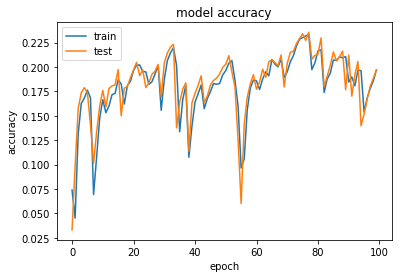

In [363]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

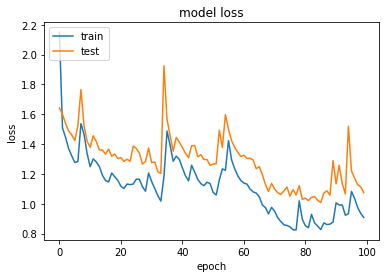

In [364]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

## Inference Mode 

In [367]:
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='relu')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.load_weights('Models/2000-relu-no-dropout.h5')

# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())

## Test it on training set 

In [396]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [397]:
def encode_sequence(sentence, encoding_dict = input_token_index):
    encoder_input_data = np.zeros((1,max_encoder_seq_length,len(encoding_dict)))
    for t, char in enumerate(sentence):
        encoder_input_data[0,t, encoding_dict[char]] = 1.
    return encoder_input_data 

In [398]:
def predictions(df_test):
    
    df_test['enconding'] = df_test.infinitivo.apply(encode_sequence).apply(decode_sequence)
    return test

In [399]:
def predictions(df_test):
    
    df_test['enconding'] = df_test.infinitivo.apply(encode_sequence).apply(decode_sequence)
    return df_test

In [400]:
for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

-
Input sentence: ir
Decoded sentence: o

-
Input sentence: ser
Decoded sentence: ereso

-
Input sentence: fazer
Decoded sentence: o

-
Input sentence: amar
Decoded sentence: asuso

-
Input sentence: estar
Decoded sentence: o

-
Input sentence: ver
Decoded sentence: eveio

-
Input sentence: vir
Decoded sentence: eveio

-
Input sentence: ter
Decoded sentence: ereso

-
Input sentence: poder
Decoded sentence: o

-
Input sentence: dar
Decoded sentence: aso

-
Input sentence: haver
Decoded sentence: veveuso

-
Input sentence: partir
Decoded sentence: o

-
Input sentence: comer
Decoded sentence: co

-
Input sentence: pÌ«r
Decoded sentence: o

-
Input sentence: dizer
Decoded sentence: eno

-
Input sentence: estudar
Decoded sentence: o

-
Input sentence: falar
Decoded sentence: o

-
Input sentence: cantar
Decoded sentence: o

-
Input sentence: rir
Decoded sentence: o

-
Input sentence: sair
Decoded sentence: o

-
Input sentence: querer
Decoded sentence: areso

-
Input sentence: trazer
Decoded 

In [401]:
decode_sequence(encode_sequence("escurecer"))

'eco\n'

## Test it on the Testing set 

In [402]:
test_file

'Corpus/test1001534627942verbs.csv'

In [412]:
def new_load_test(test_file):
    import pandas as pd

    test = pd.read_csv(test_file, 
                       sep=';', names=['infinitivo','conjugado'], encoding='latin1')
    return test
df_Test = new_load_test(test_file)

In [413]:
df_Test['encoding'] = df_Test.infinitivo.iloc[:60].apply(encode_sequence).apply(decode_sequence)

In [414]:
df_Test.head(60).values

array([['raptar', 'rapto', 'aso\n'],
       ['salgar', 'salgo', 'aulo\n'],
       ['barrar', 'barro', 'aco\n'],
       ['urinar', 'urino', 'auso\n'],
       ['inquirir', 'inquiro', 'eino\n'],
       ['empobrecer', 'empobresso', 'co\n'],
       ['alumiar', 'alumio', 'aulo\n'],
       ['abreviar', 'abrevio', 'bero\n'],
       ['folhar', 'folho', 'o\n'],
       ['desprover', 'desprovo', 'co\n'],
       ['reconvir', 'reconvenho', 'eco\n'],
       ['refutar', 'refuto', 'o\n'],
       ['cogitar', 'cogito', 'aco\n'],
       ['contrastar', 'contrasto', 'oco\n'],
       ['profetizar', 'profetizo', 'openo\n'],
       ['repudiar', 'repudio', 'po\n'],
       ['escoar', 'escoo', 'o\n'],
       ['engrandecer', 'engrandesso', 'eulo\n'],
       ['desabafar', 'desabafo', 'auso\n'],
       ['estampar', 'estampo', 'asuso\n'],
       ['aquietar', 'aquieto', 'auso\n'],
       ['assombrar', 'assombro', 'aco\n'],
       ['solussar', 'solusso', 'aulo\n'],
       ['debulhar', 'debulho', 'o\n'],
       ['lixar'

In [415]:
def test_accuracy(df, len_test):
    df_Test['encoding'] = df_Test['encoding'].apply(lambda x: str(x)[:-1])

    df_Test['conjugado'] = df_Test['conjugado'].apply(lambda x: str(x))

    df = df_Test

    matches = df[df['encoding'] == df['conjugado']]

    return float(len(matches))/len_test 

In [416]:
test_accuracy(df_Test, 60)

0.0

---